CS 1051 Final Project: Simple Diffusion Model from Scratch \\
Hayden Hunskor and Sujay Banerjee

In [ ]:
#Import statements
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import torchvision

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.nn.modules.activation import ReLU

import matplotlib.pyplot as plt

from PIL import Image

In [ ]:
IMG_SIZE = 28
BATCH_SIZE = 64

#A transform to resize, randomly flip, and scale images and convert them to tensors
transform = transforms.Compose([transforms.RandomHorizontalFlip(), #Random horizontal flip
                                transforms.ToTensor() #Convert to tensor
])

In [ ]:
#Loading in data to dataloader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Below is a diffusion class that we initially tried to borrow from another diffusion project. However, this ended up overcomplicating things so we ended up not using it. This is only here for reference. \\

Link to external source: https://github.com/tcapelle/Diffusion-Models-pytorch/blob/main/ddpm.py

In [ ]:
#@title Diffusion class (we no longer use this)
# class Diffusion:
#     def __init__(self):
#         self.noise_steps = 10
#         self.beta_start = 0.0001
#         self.beta_end = 0.02

#         self.beta = self.prepare_noise_schedule().to(DEVICE)
#         self.alpha = 1. - self.beta
#         self.alpha_hat = torch.cumprod(self.alpha, dim=0)

#     def prepare_noise_schedule(self):
#         return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

#     def noise_images(self, x, t):
#         sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None].to(DEVICE)
#         sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None].to(DEVICE)
#         Ɛ = torch.randn_like(x).to(DEVICE)
#         return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

#     def sample_timesteps(self, n):
#         return torch.randint(low=1, high=self.noise_steps, size=(n,))

#     def sample(self, model, n):
#         model.eval()
#         with torch.no_grad():
#             #x = torch.randn((n, 3, IMG_SIZE, IMG_SIZE)).to(DEVICE)
#             x = torch.randn((n, 1, IMG_SIZE, IMG_SIZE)).to(DEVICE)
            

#             for i in reversed(range(1, self.noise_steps)): #why reverse?
#                 t = (torch.ones(n) * i).long().to(DEVICE)
#                 predicted_noise = model(x)
#                 alpha = self.alpha[t][:, None, None, None]
#                 alpha_hat = self.alpha_hat[t][:, None, None, None]
#                 beta = self.beta[t][:, None, None, None]
#                 if i > 1:
#                     noise = torch.randn_like(x)
#                 else:
#                     noise = torch.zeros_like(x)
#                 x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
#         model.train()
#         x = (x.clamp(-1, 1) + 1) / 2
#         x = (x * 255).type(torch.uint8)
#         return x

Below is our initial UNet model that was inspired by a paper on biomedical image segmentation. Our implementation also repurposes some code from another diffusion project linked below. Unfortunately, because this model has too many parameters, we decided to switch to a simpler model, but we did spend a ton of time on this so we left the code.

Link to UNet paper: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ \\

Link to external code: https://github.com/tcapelle/Diffusion-Models-pytorch/blob/main/modules.py

In [ ]:
#@title Simple UNet architecture (we also no longer use this)
# class Double_Conv(nn.Module):
#   def __init__(self, in_channels, out_channels):
#     super().__init__()
#     self.conv = nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
#         nn.ReLU(),
#         nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
#         nn.ReLU()
#     )
  
#   def forward(self, x):
#     return self.conv(x)

# class Up(nn.Module):
#   def __init__(self, in_channels, out_channels, emb_dim=256):
#     super().__init__()
#     self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
#     self.conv = Double_Conv(in_channels, out_channels)
#     self.emb_layer = nn.Sequential(
#         nn.SiLU(),
#         nn.Linear(emb_dim, out_channels)
#     )

#   def forward(self, x, skip_x, t):
#     x = self.up(x)
#     x = torch.cat([x, skip_x], dim = 1)
#     x = self.conv(x)
#     emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
#     return x + emb

# class Down(nn.Module):
#   def __init__(self, in_channels, out_channels, emb_dim=256):
#     super().__init__()
#     self.conv = nn.Sequential(
#         nn.MaxPool2d(kernel_size=2, stride=2),
#         Double_Conv(in_channels, out_channels)
#     )

#     self.emb_layer = nn.Sequential(
#         nn.SiLU(),
#         nn.Linear(emb_dim, out_channels)
#     )

#   def forward(self, x, t):
#     x = self.conv(x)
#     emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
#     return x + emb

# class UNet(nn.Module):
#   def __init__(self, time_dim=256):
#     super(UNet, self).__init__()
#     self.time_dim = time_dim

#     #First conv layer
#     self.first = Double_Conv(1, 32)


#     #Down blocks
#     self.down1 = Down(32, 64)
#     self.down2 = Down(64, 128)

#     #Bottleneck
#     self.middle = Double_Conv(128, 128)

#     #Up blocks
#     self.up1 = Up(128, 64)
#     self.up2 = Up(64, 32)

#     #Final conv layer
#     self.last = Double_Conv(32, 1)

#   def forward(self, img, t):

#     #Handle positional encoding
#     t = t.unsqueeze(-1)
#     t = self.pos_encoding(t, self.time_dim).to(DEVICE)
    
#     x1 = self.first(img)
#     x2 = self.down1(x1, t)
#     x3 = self.down2(x2, t)

#     x4 = self.middle(x3)

#     x = self.up1(x4, x2, t)
#     x = self.up2(x, x1, t)
    
#     x = self.last(x)

#     return(x)

Below is a simple, deep neural network that we used to replace our UNet model. It is set up to take in a noised image concatenated with its label and corresponding noise steps, which is a tensor of size 804.

In [ ]:
#Simple deep neural network
class model_v2(nn.Module):
    def __init__(self):
      super(model_v2, self).__init__()
      self.model = nn.Sequential(
          nn.Linear(804, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, 784)
      )
    
    def forward(self, x):
      return self.model(x)

Below are some helper functions that we wrote to handle forward diffusion and one-hot encoding:

In [ ]:
#Function for one-hot encoding labels
def one_hot(input, dim):
    batch = []
    for i in input:
      label = np.zeros(dim)
      label[i] = 1
      batch.append(label)
    return torch.tensor(batch)

#Function for sampling random time steps
def sample_timesteps(t, n):
    return np.random.randint(1, t, n)

#Function that noises images
def noise_images(imgs, batch_size, t):
    noise = torch.empty(batch_size, 28*28)
    noised_imgs = torch.empty(batch_size, 28*28)

    for i, (img, t) in enumerate(zip(imgs, t)):
        img = img.view(28, 28)
        for step in range(t):
            e = torch.normal(mean = 0, std = 0.1, size = (28,28))
            img = img + e

            if step == t-1:
              noise[i] = e.view(28*28)
              noised_imgs[i] = img.view(28*28)

    return noised_imgs, noise

#Plots tensor images and undos transforms
#This function is from https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing&authuser=1#scrollTo=i7AZkYjKgQTm
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    plt.imshow(reverse_transforms(image), cmap = "gray")

The code chunk below simulates forward diffusion on a single input image. We used this code chunk to generate one of our visuals for the project.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


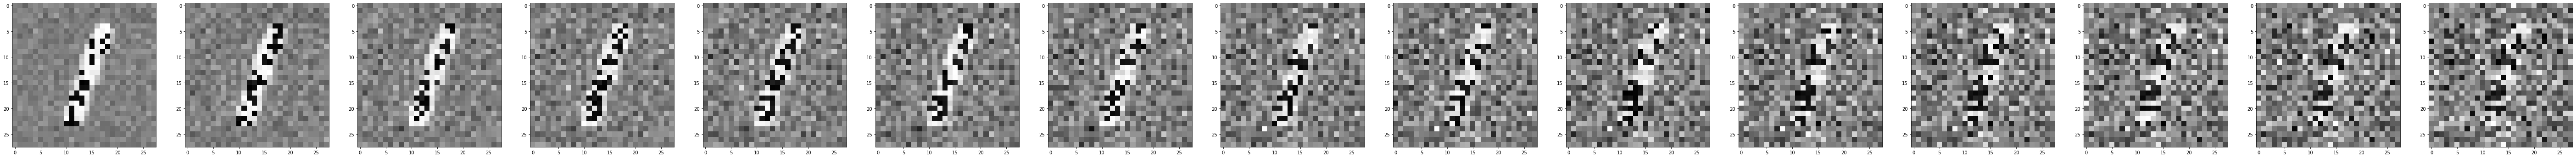

In [ ]:
#@title Simulating forward diffusion

images, labels = next(iter(dataloader))

#Function that returns noised image at each step
def progressive_img_noise(img, t):
    out = []
    e = 0
    for i in range(t):
        e = torch.normal(mean=0, std = 0.1, size = (28,28))
        img = img + e
        out.append(img)
    return out

#Call noising function
imgs = progressive_img_noise(images[0], 15)

#Plot noised image at each step
plt.figure(figsize=(100,100))
plt.axis('off')

for i in range(0, 15):
    plt.subplot(1, 15, i + 1)
    show_tensor_image(imgs[i])

In [ ]:
#@title Training the model
from torch.optim import Adam

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model_v2()
model.to(DEVICE)
optimizer = Adam(model.parameters(), lr=.000001)
time_steps = 10
epochs = 100
loss = nn.MSELoss()

all_samples = []

for epoch in range(epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(dataloader):

        batch_size = images.shape[0] #the batch size is cropped on the last iteration

        #Create random timesteps
        t = sample_timesteps(10, batch_size)

        #Noise batch of images using randomly generated time steps
        images = images.view(-1, IMG_SIZE * IMG_SIZE)
        noised_imgs, noise = noise_images(images, batch_size, t)

        #One hot encode labels
        labels = one_hot(labels, 10)

        #Sample and one hot encode time steps
        t = one_hot(t, 10)

        #Concatenate images, labels, and time steps
        input = torch.cat([images, labels, t], dim=1).to(DEVICE)
        input = input.to(torch.float32)

        #Predict noise
        predicted_noise = model(input)

        fit = loss(noise.to(DEVICE), predicted_noise)
        
        optimizer.zero_grad()
        fit.backward()
        optimizer.step()

        total_loss += fit

    print(f"epoch: {epoch} / loss: {total_loss}")
    torch.save(model.state_dict(), 'model_weights.pt') #save model weights

In [ ]:
#Loading model weights
model = model_v2()
model.load_state_dict(torch.load('model_weights.pt'))
model.to(DEVICE)

In [ ]:
#@title Testing the model
def test(model):

  #Generate randomw noise
  random_noise = torch.normal(mean=0, std = 0.1, size = (1, 784)).to(DEVICE)
  print(random_noise.shape)

  #Pick a random digit and one-hot encode label
  labels = [2]
  labels = one_hot(labels, 10).to(DEVICE)

  for i in reversed(range(10)):
    #steps = sample_timesteps(i, 1)
    steps = np.array([1])
    steps = one_hot(steps, 10).to(DEVICE)
    print(steps.shape)

    input = torch.cat([random_noise, labels, steps], dim=1).to(DEVICE)
    print(input.shape)
    input = input.to(torch.float32)

    predicted_noise = model(input)
    print(predicted_noise.shape)
    random_noise = random_noise - predicted_noise
    print(random_noise.shape)

  return random_noise

test_img = test(model).cpu()
test_img = test_img.view(1, 28, 28).squeeze(0)

test_img = test_img.detach().numpy()

plt.imshow(test_img, cmap = 'gray')
